<br>

На входе есть данные по продажам - дата, номер заказа и сумма заказа. <br>
Задача проанализировать распределение, понять кто из клиентов приносит больше денег.

#### Импорт и подготовка данных для анализа

Импортирую библиотеки

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

%matplotlib inline

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Импортирую данные

In [3]:
df = pd.read_csv(os.getcwd() + '/randOrders.csv', index_col=0)

In [4]:
df.shape

(16523, 3)

In [5]:
df.head()

,date,orderID,purchase
0,2020-03-03,98610,11910
1,2020-03-03,98611,10950
2,2020-03-03,98612,8180
3,2020-03-03,98613,60644
4,2020-03-03,98614,17120


In [6]:
df.dtypes

date        object
orderID      int64
purchase     int64
dtype: object

Привожу данные в нужный формат

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['orderID'] = df['orderID'].astype(int)

In [8]:
df.dtypes

date        datetime64[ns]
orderID              int64
purchase             int64
dtype: object

In [9]:
df.head()

,date,orderID,purchase
0,2020-03-03,98610,11910
1,2020-03-03,98611,10950
2,2020-03-03,98612,8180
3,2020-03-03,98613,60644
4,2020-03-03,98614,17120


#### Описательные статистики и распределение сумм заказов

Хочу взглянуть на описательные статистики, понять общую картину.

In [10]:
df['purchase'].describe().round()[1:10]

mean       35353.0
std       211559.0
min         5240.0
25%        12220.0
50%        17513.0
75%        27510.0
max     19077520.0
Name: purchase, dtype: float64

* Можно заметить, что среднее смещенно относительно медианы; <br>
* Есть сильный разброс между минимальной и максимальной стоимостью заказа; <br>
* Как видно стандартное отклонение около 200 тыс и 75% всех заказов лежат в пределах 28 тыс.

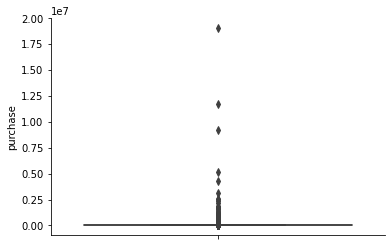

In [11]:
sns.boxplot(y='purchase', data=df)
sns.despine()

* На диаграмме видно, есть некоторые очень крупные заказы;
* Большая часть заказов имеет небольшой срений чек;
* Из описательной статистики средний чек составляет 17 тыс.

Дальше, на другом распределении, лучше видно это смещение.

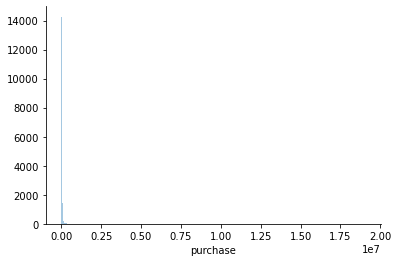

In [12]:
sns.distplot(df['purchase'], kde=False, bins=500)
sns.despine()

<br>

#### Внутренняя логика сегментирования

Чтобы отсечь крупные заказы, которые оттягивают среднее и посмотреть более детально на распределение, нужно убрать выбросы.

In [13]:
df['purchase'].quantile(0.95).round()

84103.0

И так, выше можно увидеть, что 95% всех покупок совершаются до 100 тыс.

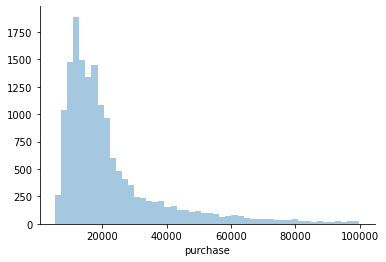

In [18]:
sns.distplot(df[df['purchase'] < 100000]['purchase'], kde=False);
sns.despine()

In [20]:
df['purchase'].describe().round()[2:10]

std      211559.0
min        5240.0
25%       12220.0
50%       17513.0
75%       27510.0
max    19077520.0
Name: purchase, dtype: float64

In [21]:
df['purchase'].quantile(0.95).round()

84103.0

Можно увидеть, что до 25% всех покупок клиенты с чеком до 12 тыс.<br>
Поэтому первый сегмент - те, кто покупает ниже этой суммы. <br>
И тогда распределить сегменты следующим образом:<br>

* Первый сегмент - от минимальной стоимости заказа до 12 тыс;<br>
* Второй сегмент - клиенты со средним чеком от 12 до 17 тыс;<br>
* Третий сегмент - клиенты со средним чеком от 17 до 27 тыс;<br>
* Четвертый сегмент - клиенты со средним чеком от 27 до 84 тыс;<br>
* И пятый сегмент - клиенты с чеком от 84 тыс и выше.<br>

Последний составляет 5% от всех покупок - потенциально новый сегмент на который можно попробовать выйти.

#### Проведение сегментации и выводы

In [22]:
bins = [0, 12000, 17000, 27000, 84000, 19077520]

In [23]:
df['segment'] = pd.cut(df['purchase'], bins=bins, labels=[1, 2, 3, 4, 5])

In [24]:
df.head()

,date,orderID,purchase,segment
0,2020-03-03,98610,11910,1
1,2020-03-03,98611,10950,1
2,2020-03-03,98612,8180,1
3,2020-03-03,98613,60644,4
4,2020-03-03,98614,17120,3


Ниже на графике можно увидеть, сколько каждый сегмент приносит денег.<br>
На основании даных с апреля 2020 по декабрь 2021, за 21 месяц.

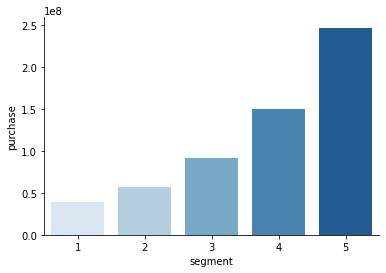

In [52]:
sns.barplot(x='segment', y='purchase', 
            data=df.groupby('segment', as_index=False).agg({'purchase': 'sum'}).round(), 
            palette='Blues');
sns.despine()